In [124]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [125]:
# ДЗ 2
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

In [126]:
image = cv2.imread('img.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

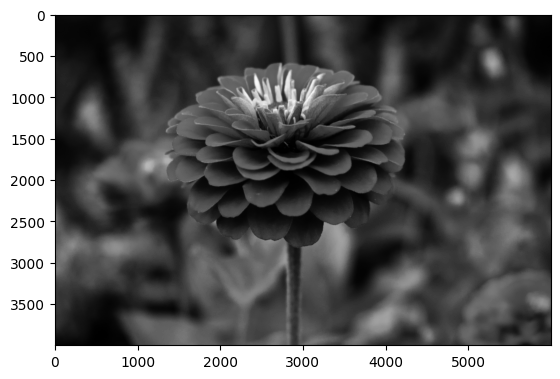

In [127]:
plt.imshow(image_gray, cmap="gray")

Функция для оценки качества фильтрации

In [128]:
def evaluate_filter(original, filtered):
    psnr_value = psnr(original, filtered)
    ssim_value = ssim(original, filtered)
    return psnr_value, ssim_value

1. Зашумить изображение при помощи шума гаусса, постоянного шума.

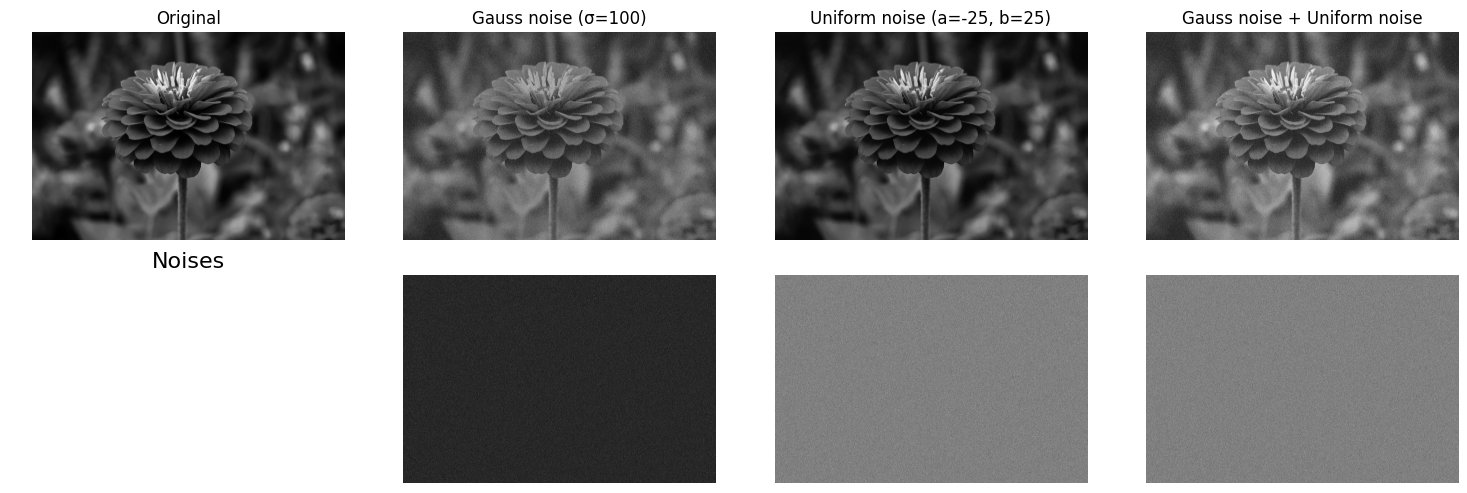

Original vs Original with gauss noise.
	PSNR: 12.424262624264932, SSIM: 0.027877482225691606
Original vs Original with uniform noise.
	PSNR: 25.150423346681194, SSIM: 0.2982126790758791
Original vs Original with gauss && uniform noises.
	PSNR: 11.465044251246113, SSIM: 0.024240190980982255


In [129]:
# save noises images
images_noise = {}

fig, axes = plt.subplots(2, 4, figsize=(15, 5))

axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[1, 0].set_title('Noises', fontsize=16, pad=5)
axes[1, 0].axis('off')

# create gauss noise
mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)

axes[1, 1].imshow(noise_gauss, cmap='gray')
axes[1, 1].axis('off')

# create uniform noise
a, b = -25, 25
noise_uniform = np.random.uniform(a, b, image_gray.shape)
axes[1, 2].imshow(noise_uniform, cmap='gray')
axes[1, 2].axis('off')

# create gausse + uniform noise
noise_gauss_uniform = noise_gauss + noise_uniform
axes[1, 3].imshow(noise_uniform, cmap='gray')
axes[1, 3].axis('off')

# original + gauss noise
image_noise_gauss = np.clip(image_gray + noise_gauss, 0, 255).astype(np.uint8)
images_noise[f'Gauss noise (σ={stddev})'] = image_noise_gauss

# original + uniform noise
image_noise_uniform = np.clip(image_gray + noise_uniform, 0, 255).astype(np.uint8)
images_noise[f'Uniform noise (a={a}, b={b})'] = image_noise_uniform

# original + gauss noise + uniform noise
image_noise_gauss_uniform = np.clip(image_gray + noise_gauss_uniform, 0, 255).astype(np.uint8)
images_noise[f'Gauss noise + Uniform noise'] = image_noise_gauss_uniform

for col, key in enumerate(images_noise, start=1):
    axes[0, col].imshow(images_noise[key], cmap='gray')
    axes[0, col].set_title(key)
    axes[0, col].axis('off')

plt.tight_layout()
plt.show()

print("Original vs Original with gauss noise.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_gauss)))
print("Original vs Original with uniform noise.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_uniform)))
print("Original vs Original with gauss && uniform noises.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_gauss_uniform)))

2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.

In [130]:
results = {}

filters = [
    ('Median', cv2.medianBlur),
    ('Gaussian', cv2.GaussianBlur),
    ('Bilateral', cv2.bilateralFilter),
    ('NlMeans', cv2.fastNlMeansDenoising)
]

# 1. Медианный фильтр с различными размерами ядра
kernel_sizes = [3, 5, 7, 9]
for size in kernel_sizes:
    # Для гауссова шума
    med_gauss = cv2.medianBlur(image_noise_gauss, size)
    psnr_val, ssim_val = evaluate_filter(image_gray, med_gauss)
    results[f'Медианный (гауссов шум, ядро={size})'] = (med_gauss, psnr_val, ssim_val)
    
    # Для постоянного шума
    med_unif = cv2.medianBlur(image_noise_uniform, size)
    psnr_val, ssim_val = evaluate_filter(image_gray, med_unif)
    results[f'Медианный (постоянный шум, ядро={size})'] = (med_unif, psnr_val, ssim_val)

    # И для того и для того
    med_gauss_unif = cv2.medianBlur(image_noise_gauss_uniform, size)
    psnr_val, ssim_val = evaluate_filter(image_gray, med_gauss_unif)
    results[f'Медианный (гауссов и постоянный шум, ядро={size})'] = (med_gauss_unif, psnr_val, ssim_val)



# 2. Гауссов фильтр с различными параметрами
kernel_sizes = [3, 5, 7]
sigmas = [1, 2, 3]
for size in kernel_sizes:
    for sigma in sigmas:
        # Для гауссова шума
        gauss_gauss = cv2.GaussianBlur(image_noise_gauss, (size, size), sigma)
        psnr_val, ssim_val = evaluate_filter(image_gray, gauss_gauss)
        results[f'Гауссов (гауссов шум, ядро={size}, σ={sigma})'] = (gauss_gauss, psnr_val, ssim_val)
        
        # Для постоянного шума
        gauss_unif = cv2.GaussianBlur(image_noise_uniform, (size, size), sigma)
        psnr_val, ssim_val = evaluate_filter(image_gray, gauss_unif)
        results[f'Гауссов (постоянный шум, ядро={size}, σ={sigma})'] = (gauss_unif, psnr_val, ssim_val)

        # Для гауссова и постоянного шума
        gauss_gauss_unif = cv2.GaussianBlur(image_noise_gauss_uniform, (size, size), sigma)
        psnr_val, ssim_val = evaluate_filter(image_gray, gauss_gauss_unif)
        results[f'Гауссов (гауссов и постоянный шум, ядро={size}, σ={sigma})'] = (gauss_gauss_unif, psnr_val, ssim_val)

# 3. Билатеральный фильтр с различными параметрами
d_values = [5, 9, 15]
sigma_color_values = [25, 50, 75]
sigma_space_values = [25, 50, 75]

for d in d_values:
    for sigma_color in sigma_color_values:
        for sigma_space in sigma_space_values:
            # Для гауссова шума
            bilateral_gauss = cv2.bilateralFilter(image_noise_gauss, d, sigma_color, sigma_space)
            psnr_val, ssim_val = evaluate_filter(image_gray, bilateral_gauss)
            results[f'Билатеральный (гауссов шум, d={d}, σ_color={sigma_color}, σ_space={sigma_space})'] = (bilateral_gauss, psnr_val, ssim_val)
            
            # Для постоянного шума
            bilateral_unif = cv2.bilateralFilter(image_noise_uniform, d, sigma_color, sigma_space)
            psnr_val, ssim_val = evaluate_filter(image_gray, bilateral_unif)
            results[f'Билатеральный (постоянный шум, d={d}, σ_color={sigma_color}, σ_space={sigma_space})'] = (bilateral_unif, psnr_val, ssim_val)

            # Для гауссова и постоянного шума
            bilateral_gauss_unif = cv2.bilateralFilter(image_noise_gauss_uniform, d, sigma_color, sigma_space)
            psnr_val, ssim_val = evaluate_filter(image_gray, bilateral_gauss_unif)
            results[f'Билатеральный (гауссов и постоянный шум, d={d}, σ_color={sigma_color}, σ_space={sigma_space})'] = (bilateral_gauss_unif, psnr_val, ssim_val)

# 4. Нелокальный Means фильтр с различными параметрами
h_values = [10, 20, 30]
template_window_sizes = [7, 11]
search_window_sizes = [21, 35]

for h in h_values:
    for template_size in template_window_sizes:
        for search_size in search_window_sizes:
            # Для гауссова шума
            nlm_gauss = cv2.fastNlMeansDenoising(image_noise_gauss, None, h, template_size, search_size)
            psnr_val, ssim_val = evaluate_filter(image_gray, nlm_gauss)
            results[f'Нелокальный Means (гауссов шум, h={h}, template={template_size}, search={search_size})'] = (nlm_gauss, psnr_val, ssim_val)
            
            # Для постоянного шума
            nlm_unif = cv2.fastNlMeansDenoising(image_noise_uniform, None, h, template_size, search_size)
            psnr_val, ssim_val = evaluate_filter(image_gray, nlm_unif)
            results[f'Нелокальный Means (постоянный шум, h={h}, template={template_size}, search={search_size})'] = (nlm_unif, psnr_val, ssim_val)

            # Для гауссова и постоянного шума
            nlm_gauss_unif = cv2.fastNlMeansDenoising(image_noise_gauss_uniform, None, h, template_size, search_size)
            psnr_val, ssim_val = evaluate_filter(image_gray, nlm_gauss_unif)
            results[f'Нелокальный Means (гауссов и постоянный шум, h={h}, template={template_size}, search={search_size})'] = (nlm_gauss_unif, psnr_val, ssim_val)

# Находим лучшие результаты для каждого типа шума и фильтра
best_results = {}
for key in results:
    noise_type = "гауссов и постоянный" if "гауссов и постоянный" in key else ("постоянный" if "постоянный" in key else "гауссов")
    filter_type = key.split(' ')[0]
    
    if (noise_type, filter_type) not in best_results:
        best_results[(noise_type, filter_type)] = (key, results[key][1], results[key][2])
    else:
        # Сравниваем по PSNR (чем выше, тем лучше)
        if results[key][1] > best_results[(noise_type, filter_type)][1]:
            best_results[(noise_type, filter_type)] = (key, results[key][1], results[key][2])

# Выводим лучшие результаты
print("Лучшие результаты фильтрации:")
print("-" * 80)
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    print(f"{filter_type} фильтр для {noise_type} шума: PSNR = {psnr_val:.2f}, SSIM = {ssim_val:.4f}")
    print(f"\tПараметры: {key}\n")



Лучшие результаты фильтрации:
--------------------------------------------------------------------------------
Медианный фильтр для гауссов шума: PSNR = 29.16, SSIM = 0.7179
	Параметры: Медианный (гауссов шум, ядро=9)

Медианный фильтр для постоянный шума: PSNR = 35.14, SSIM = 0.8071
	Параметры: Медианный (постоянный шум, ядро=9)

Медианный фильтр для гауссов и постоянный шума: PSNR = 22.74, SSIM = 0.6680
	Параметры: Медианный (гауссов и постоянный шум, ядро=9)

Гауссов фильтр для гауссов шума: PSNR = 17.48, SSIM = 0.4906
	Параметры: Гауссов (гауссов шум, ядро=7, σ=3)

Гауссов фильтр для постоянный шума: PSNR = 35.80, SSIM = 0.8216
	Параметры: Гауссов (постоянный шум, ядро=7, σ=3)

Гауссов фильтр для гауссов и постоянный шума: PSNR = 16.22, SSIM = 0.4567
	Параметры: Гауссов (гауссов и постоянный шум, ядро=7, σ=3)

Билатеральный фильтр для гауссов шума: PSNR = 17.30, SSIM = 0.1496
	Параметры: Билатеральный (гауссов шум, d=15, σ_color=75, σ_space=75)

Билатеральный фильтр для постоянный 

3. Выяснить, какой фильтр показал лучший результат фильтрации шума.

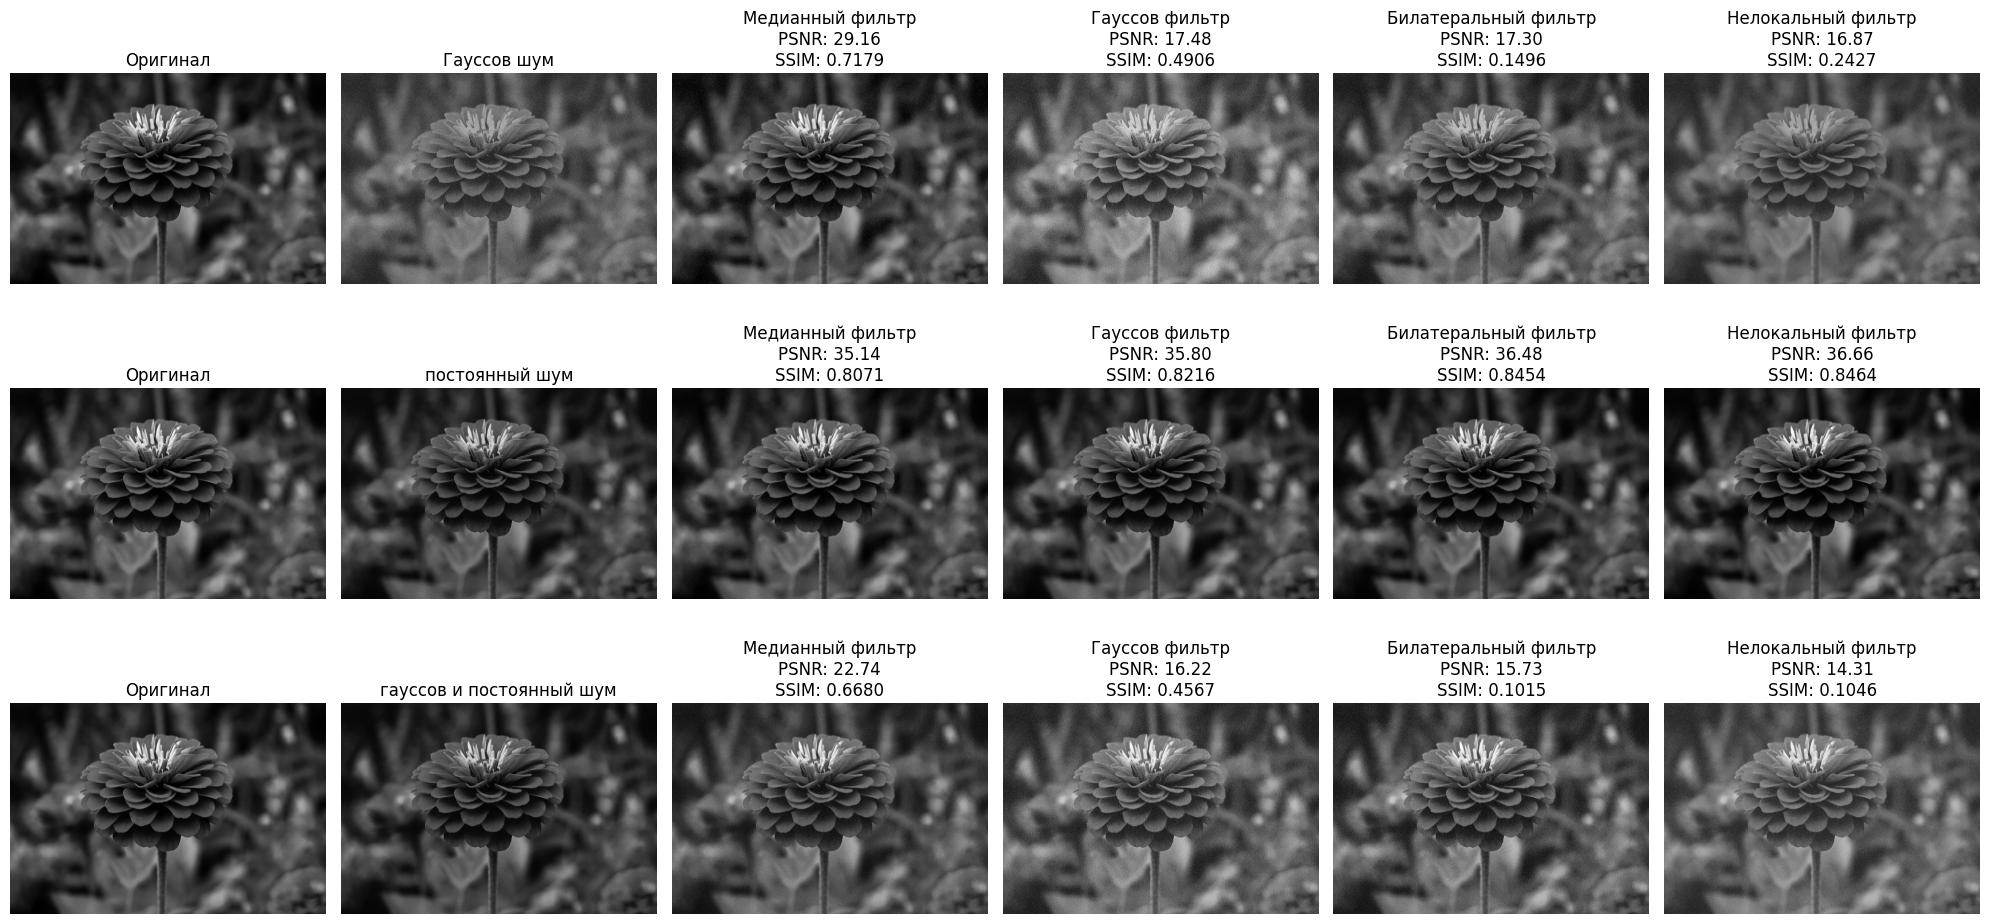


ОБЩИЕ РЕЗУЛЬТАТЫ:
--------------------------------------------------------------------------------
Лучший фильтр для гауссова шума: Медианный (гауссов шум, ядро=9)
  PSNR: 29.16, SSIM: 0.7179

Лучший фильтр для постоянного шума: Нелокальный Means (постоянный шум, h=20, template=7, search=21)
  PSNR: 36.66, SSIM: 0.8464

Лучший фильтр для гауссова и постоянного шума: Медианный (гауссов и постоянный шум, ядро=9)
  PSNR: 22.74, SSIM: 0.6680


In [132]:
# Визуализируем лучшие результаты для каждого типа шума
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

# Гауссов шум
axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Оригинал')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_noise_gauss, cmap='gray')
axes[0, 1].set_title('Гауссов шум')
axes[0, 1].axis('off')

# Лучшие результаты для гауссова шума
best_gaussian = {}
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    if noise_type == "гауссов":
        best_gaussian[filter_type] = results[key][0]

row = 0
col = 2
for filter_type, filtered_img in best_gaussian.items():
    axes[row, col].imshow(filtered_img, cmap='gray')
    axes[row, col].set_title(f'{filter_type} фильтр\nPSNR: {best_results[("гауссов", filter_type)][1]:.2f}\nSSIM: {best_results[("гауссов", filter_type)][2]:.4f}')
    axes[row, col].axis('off')
    col += 1

# Постоянный шум
axes[1, 0].imshow(image_gray, cmap='gray')
axes[1, 0].set_title('Оригинал')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_noise_uniform, cmap='gray')
axes[1, 1].set_title('постоянный шум')
axes[1, 1].axis('off')

# Лучшие результаты для импульсного шума
best_unif = {}
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    if noise_type == "постоянный":
        best_unif[filter_type] = results[key][0]

row = 1
col = 2
for filter_type, filtered_img in best_unif.items():
    axes[row, col].imshow(filtered_img, cmap='gray')
    axes[row, col].set_title(f'{filter_type} фильтр\nPSNR: {best_results[("постоянный", filter_type)][1]:.2f}\nSSIM: {best_results[("постоянный", filter_type)][2]:.4f}')
    axes[row, col].axis('off')
    col += 1

# Гауссов и Постоянный шум
axes[2, 0].imshow(image_gray, cmap='gray')
axes[2, 0].set_title('Оригинал')
axes[2, 0].axis('off')

axes[2, 1].imshow(image_noise_uniform, cmap='gray')
axes[2, 1].set_title('гауссов и постоянный шум')
axes[2, 1].axis('off')

# Лучшие результаты для постоянного шума
best_gauss_unif = {}
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    if noise_type == "гауссов и постоянный":
        best_gauss_unif[filter_type] = results[key][0]

row = 2
col = 2
for filter_type, filtered_img in best_gauss_unif.items():
    axes[row, col].imshow(filtered_img, cmap='gray')
    axes[row, col].set_title(f'{filter_type} фильтр\nPSNR: {best_results[("гауссов и постоянный", filter_type)][1]:.2f}\nSSIM: {best_results[("гауссов и постоянный", filter_type)][2]:.4f}')
    axes[row, col].axis('off')
    col += 1

plt.tight_layout()
plt.show()

# Определяем общих победителей
best_gauss_overall = max([(key, psnr, ssim) for (noise_type, filter_type), (key, psnr, ssim) in best_results.items() if noise_type == "гауссов"], key=lambda x: x[1])
best_unif_overall = max([(key, psnr, ssim) for (noise_type, filter_type), (key, psnr, ssim) in best_results.items() if noise_type == "постоянный"], key=lambda x: x[1])
best_gauss_unif_overall = max([(key, psnr, ssim) for (noise_type, filter_type), (key, psnr, ssim) in best_results.items() if noise_type == "гауссов и постоянный"], key=lambda x: x[1])

print("\nОБЩИЕ РЕЗУЛЬТАТЫ:")
print("-" * 80)
print(f"Лучший фильтр для гауссова шума: {best_gauss_overall[0]}")
print(f"  PSNR: {best_gauss_overall[1]:.2f}, SSIM: {best_gauss_overall[2]:.4f}")
print()
print(f"Лучший фильтр для постоянного шума: {best_unif_overall[0]}")
print(f"  PSNR: {best_unif_overall[1]:.2f}, SSIM: {best_unif_overall[2]:.4f}")
print()
print(f"Лучший фильтр для гауссова и постоянного шума: {best_gauss_unif_overall[0]}")
print(f"  PSNR: {best_gauss_unif_overall[1]:.2f}, SSIM: {best_gauss_unif_overall[2]:.4f}")